In [30]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import hashlib
import seaborn as sns

In [31]:
# Define the path to your dataset
dataset="/Users/md.mahedihassan/My Data/Thesis Diabetic/Days/Aug 01/colored_images"; 

In [21]:
# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
SEED = 1337
DATASET_DIR = dataset

In [23]:

# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Found 3662 files belonging to 5 classes.
Using 732 files for validation.


In [24]:
# Get class names from the dataset
class_names = train_ds.class_names
n_classes = len(class_names)
print("Class names (locked):", class_names)


Class names (locked): ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [25]:
test_root = os.path.join(os.path.dirname(DATASET_DIR), "test")
if os.path.isdir(test_root):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_root,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
else:
    test_ds = val_ds.unbatch().batch(BATCH_SIZE)  # fallback

In [28]:
# Unified image preprocessing function for both training and prediction
IMG_SIZE = (256, 256)

def preprocess_image(path):
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # match Rescaling(1./255) used in training
    return tf.expand_dims(img_array, 0)  # add batch dimension

In [29]:
# Display a batch of images and labels
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy().astype("uint8"))

(32, 256, 256, 3)
[2 2 1 1 2 2 1 1 2 0 4 2 1 2 3 1 1 1 1 1 2 0 2 2 2 2 2 1 1 2 1 2]


EDA

In [33]:
# Initialize lists to store image information
image_info = []
hashes = set()
duplicate_files = []
corrupt_files = []

In [34]:
# Scan dataset
for root, dirs, files in os.walk(dataset):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            try:
                # Check if image is corrupt
                img = Image.open(file_path)
                img.verify()

                # Reload image for processing
                img = Image.open(file_path).convert("RGB")
                width, height = img.size
                img_np = np.array(img)

                # Detect duplicates using MD5 hash
                file_hash = hashlib.md5(img.tobytes()).hexdigest()
                if file_hash in hashes:
                    duplicate_files.append(file_path)
                    continue
                hashes.add(file_hash)

                # Class name (assuming folder name is class label)
                label = os.path.basename(root)

                # Calculate color statistics
                mean_colors = np.mean(img_np, axis=(0, 1))  # R, G, B mean
                std_colors = np.std(img_np, axis=(0, 1))    # R, G, B std

                image_info.append({
                    "path": file_path,
                    "label": label,
                    "width": width,
                    "height": height,
                    "mean_R": mean_colors[0],
                    "mean_G": mean_colors[1],
                    "mean_B": mean_colors[2],
                    "std_R": std_colors[0],
                    "std_G": std_colors[1],
                    "std_B": std_colors[2]
                })

            except Exception:
                corrupt_files.append(file_path)

In [35]:
#Create DataFrame
df = pd.DataFrame(image_info)

print("\n--- Dataset Summary ---")
print(f"Total images: {len(df)}")
print(f"Unique classes: {df['label'].nunique()}")
print("\nClass distribution:\n", df['label'].value_counts())

print(f"\nCorrupt files: {len(corrupt_files)}")
print(f"Duplicate files: {len(duplicate_files)}")


--- Dataset Summary ---
Total images: 3534
Unique classes: 5

Class distribution:
 label
No_DR             1796
Moderate           939
Mild               348
Proliferate_DR     274
Severe             177
Name: count, dtype: int64

Corrupt files: 0
Duplicate files: 128


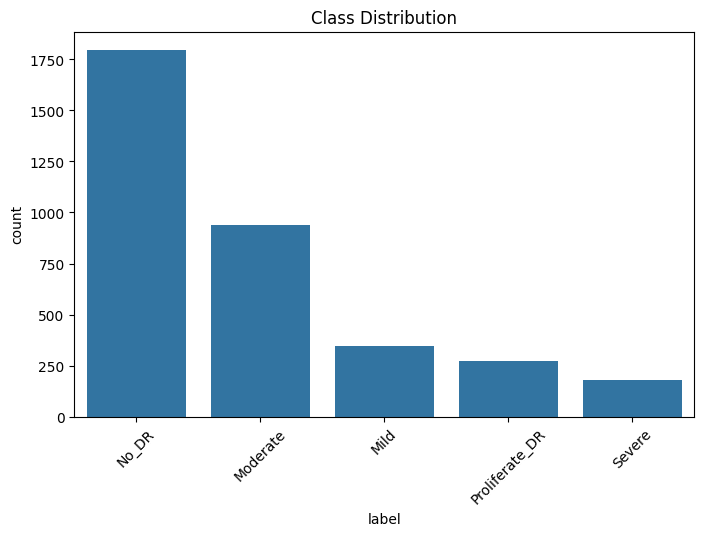

In [36]:
# Class distribution plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label", order=df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

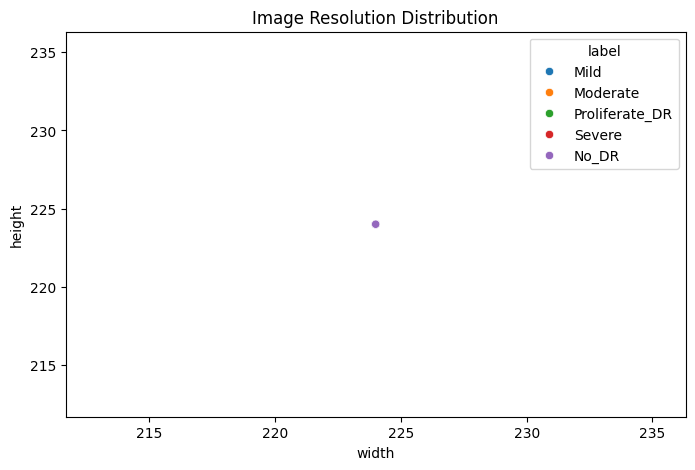

In [37]:
#Image size distribution
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="width", y="height", hue="label")
plt.title("Image Resolution Distribution")
plt.show()

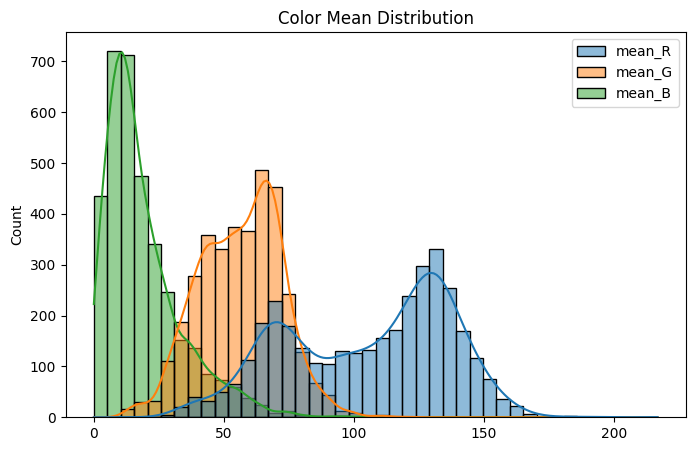

In [38]:
# 7️⃣ Color channel mean distribution
plt.figure(figsize=(8, 5))
sns.histplot(df[['mean_R', 'mean_G', 'mean_B']], kde=True)
plt.title("Color Mean Distribution")
plt.show()

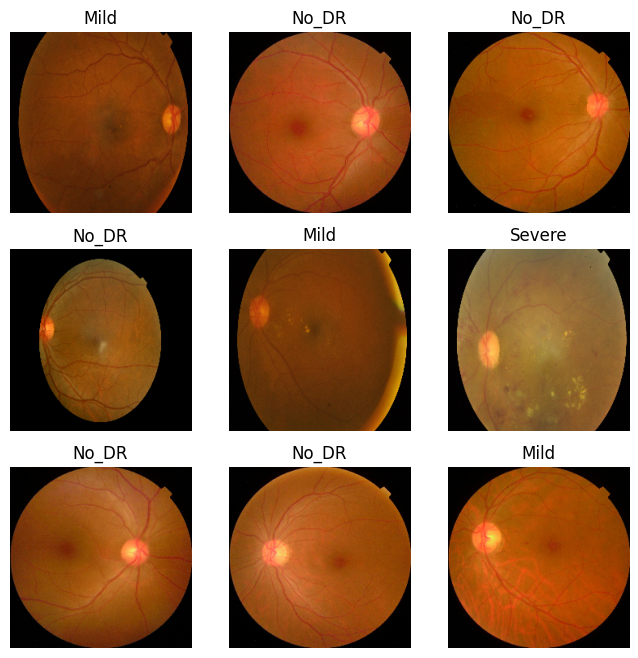

In [39]:
#Show sample images
sample_df = df.sample(min(9, len(df)), random_state=42)
plt.figure(figsize=(8, 8))
for i, row in enumerate(sample_df.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(row.label)
plt.show()

In [40]:
pd.Series(duplicate_files).to_csv("duplicate_images.csv", index=False)
pd.Series(corrupt_files).to_csv("corrupt_images.csv", index=False)

Image Visualization

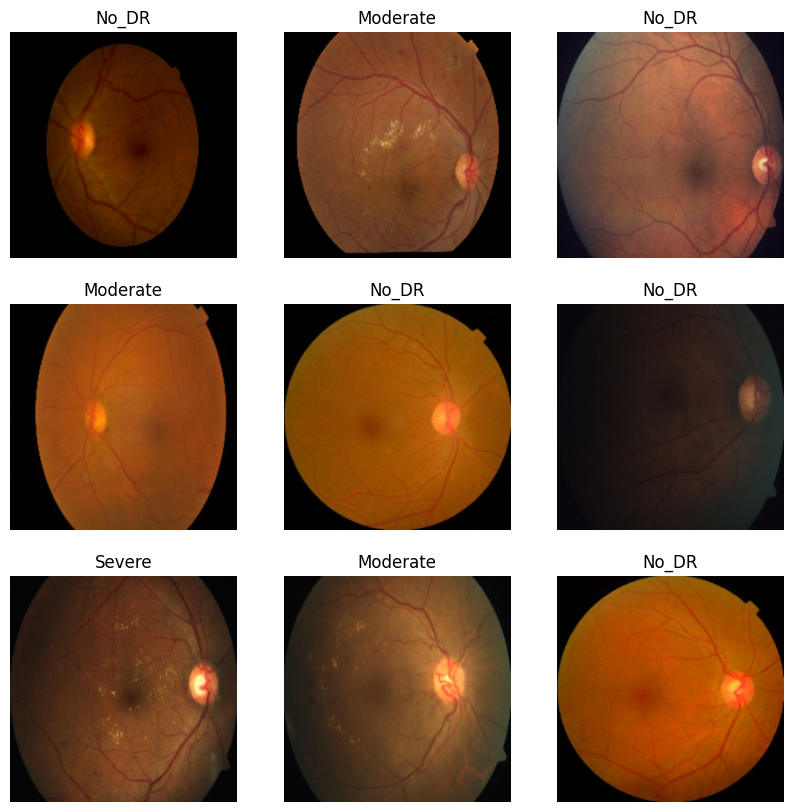

2025-08-13 22:08:00.622261: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# Display a batch of images with their labels
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.show()

Dividing Dataset in Training set and test set

In [42]:
# Function to get dataset partitions in TensorFlow
train_size=0.8
len(dataset)
#adjust the number of training samples based on the train_size percentage

73

In [43]:
# the train size 80% of the dataset
train_size=0.8
len(dataset)*train_size

58.400000000000006

In [44]:
#adjust the number of training samples based on the train_size percentage
train_ds = train_ds.take(58)
len(train_ds)

58

In [45]:
# Create a test dataset by skipping the first 58 samples
test_ds = train_ds.skip(58) 
len(test_ds)

0

In [46]:
# Define the validation size percentage
val_size = 0.1
len(dataset) * val_size


7.300000000000001

In [47]:

val_ds = test_ds.take(7) # Adjust the number of validation samples based on the val_size percentage
len(val_ds)              # Adjust the number of validation samples based on the val_size percentage


0

In [48]:
# Create a test dataset by skipping the first 6 samples
test_ds = train_ds.skip(6) 
len(test_ds)


52

Dividing Dataset in Training set and test set using TensorFlow

In [50]:
## Function to get dataset partitions in TensorFlow
def get_dataset_partitions_tf(dataset, train_size=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_size + val_split + test_split == 1.0)
    ds_size = len(dataset)

    ds = dataset
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=13)

    train_count = int(train_size * ds_size)
    val_count = int(val_split * ds_size)
    test_count = int(test_split * ds_size)

    train_ds = ds.take(train_count)
    val_ds = ds.skip(train_count).take(val_count)
    test_ds = ds.skip(train_count + val_count).take(test_count)

    return train_ds, val_ds, test_ds

In [51]:
# Fix: Make sure the splits sum to 1.0
# For example: train_ratio=0.8, val_ratio=0.1, test_ratio=0.1
train_ds, val_ds, test_ds = get_dataset_partitions_tf(
	train_ds, 
	train_size=0.8, 
	val_split=0.1, 
	test_split=0.1
)

In [52]:
# Print the sizes of the datasets
len(train_ds), len(val_ds), len(test_ds)

(46, 5, 5)

In [53]:
# Cache and prefetch the datasets for performance optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Cache and prefetch the training dataset
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)     # Cache and prefetch the validation dataset
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  # Cache and prefetch the test dataset

In [54]:
# Display a single image from the training dataset with normalized pixel values
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch[0].numpy()/255)

[[[0.00784314 0.         0.00784314]
  [0.01421569 0.00318627 0.01102941]
  [0.01029412 0.00122549 0.00906863]
  ...
  [0.01053922 0.00269608 0.01053922]
  [0.00857843 0.         0.00784314]
  [0.01176471 0.         0.00784314]]

 [[0.01102941 0.00318627 0.01102941]
  [0.00963542 0.00119485 0.00903799]
  [0.0083027  0.00022978 0.00807292]
  ...
  [0.00934436 0.00050551 0.00834865]
  [0.01056985 0.         0.00784314]
  [0.00857843 0.         0.00784314]]

 [[0.00637255 0.00122549 0.00637255]
  [0.00975797 0.00242034 0.00975797]
  [0.01053922 0.00269608 0.01053922]
  ...
  [0.01378676 0.00370711 0.01155024]
  [0.00883885 0.         0.00784314]
  [0.00784314 0.         0.00784314]]

 ...

 [[0.01053922 0.00269608 0.01053922]
  [0.00834865 0.00050551 0.00834865]
  [0.00784314 0.         0.00784314]
  ...
  [0.00945159 0.00038297 0.0082261 ]
  [0.01006434 0.00122549 0.00906863]
  [0.00906863 0.00122549 0.00906863]]

 [[0.01004902 0.00073529 0.00857843]
  [0.00825674 0.00013787 0.00798101]


In [55]:
# Display a single image shape from the training dataset
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch[0].numpy().shape)

(256, 256, 3)


In [56]:
# Resize and rescale the images using a Sequential model
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.Rescaling(1.0/255)
])

In [57]:
# Data augmentation to improve model generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

1st end
2nd start

Model Create

In [58]:
# Define constants (from your notebook)
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
CHANNELS = 3
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
n_classes = len(class_names) # This will correctly be 5
EPOCHS = 100

# Define preprocessing layers
resize_and_rescale = models.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.Rescaling(1./255)
])
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Define input shape
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)

# Define model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation="softmax") # This will be Dense(5)
])
# Corrected model.build call
model.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Optional: Inspect model architecture
model.summary()

/Users/md.mahedihassan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,872,133 (64.36 MB)

 Trainable params: 16,871,685 (64.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [59]:
# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
# Compute class weights to handle imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

labels_list = []
for images, labels in train_ds:
    labels_list.extend(labels.numpy())

class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_list),
    y=labels_list
)

class_weights = {i: w for i, w in enumerate(class_weights_values)}
print("Class Weights:", class_weights)

ModuleNotFoundError: No module named 'sklearn'

In [32]:
# Train the model with the training dataset and validate with the validation dataset
# Train the model (this assumes train_ds and val_ds are correctly loaded)
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
) 

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4185 - loss: 10.0253 - val_accuracy: 0.1187 - val_loss: 8.5863
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.4769 - loss: 1.7914 - val_accuracy: 0.2625 - val_loss: 14.0206
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.4952 - loss: 1.7747 - val_accuracy: 0.2562 - val_loss: 13.3594
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5007 - loss: 1.4812 - val_accuracy: 0.2625 - val_loss: 18.3830
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.4986 - loss: 1.4448 - val_accuracy: 0.2625 - val_loss: 21.0732
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.5000 - loss: 1.3986 - val_accuracy: 0.3125 - val_loss: 8.9287
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.4959 - loss: 1.4288 - val_accuracy: 0.3625 - val_loss: 7.4992
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.4993 - loss: 1.3853 - val_accuracy: 0.475

In [35]:
# Evaluate the model on the test dataset
len(test_ds)

5

In [36]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.5063 - loss: 1.3465


In [37]:
# Print the evaluation
scores

[1.3465421199798584, 0.5062500238418579]

In [38]:
# Display training history keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
# Extract accuracy and loss from the training history
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
len(history.history['accuracy'])

loss=history.history['loss']
val_loss=history.history['val_loss']
len(history.history['loss'])

50

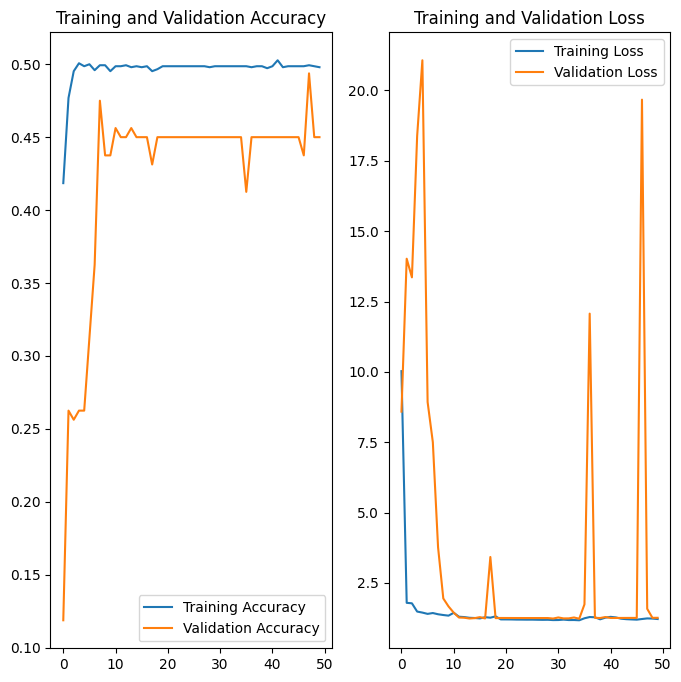

In [40]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy') 
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual Label: Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted Label: No_DR


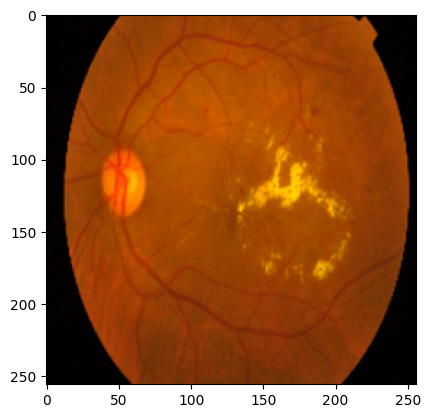

In [41]:
# Predicting on a single image from the test dataset
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[labels_batch[0].numpy()])
    batch_prediction = model.predict(tf.expand_dims(image_batch[0], 0))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [45]:
# Function to predict the class of a single image
import numpy as np
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    image_array = tf.expand_dims(image_array, 0)  # Add batch dimension
    predictions = model.predict(image_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [32]:
# Prediction function using the unified preprocessing
def predict_image(model, img_path, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = 100 * np.max(predictions[0])
    return predicted_class, confidence

# Example usage:
img_path = "test_image.jpg"
pred_class, conf = predict_image(model, img_path, class_names)
print(f"Predicted: {pred_class} ({conf:.2f}%)")

NameError: name 'model' is not defined

Labels in batch: [1 2 0 1 2 2 1 3 2 2 1 2 2 3 2 2 0 1 0 2 0 2 0 2 3 2 2 3 2 1 2 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


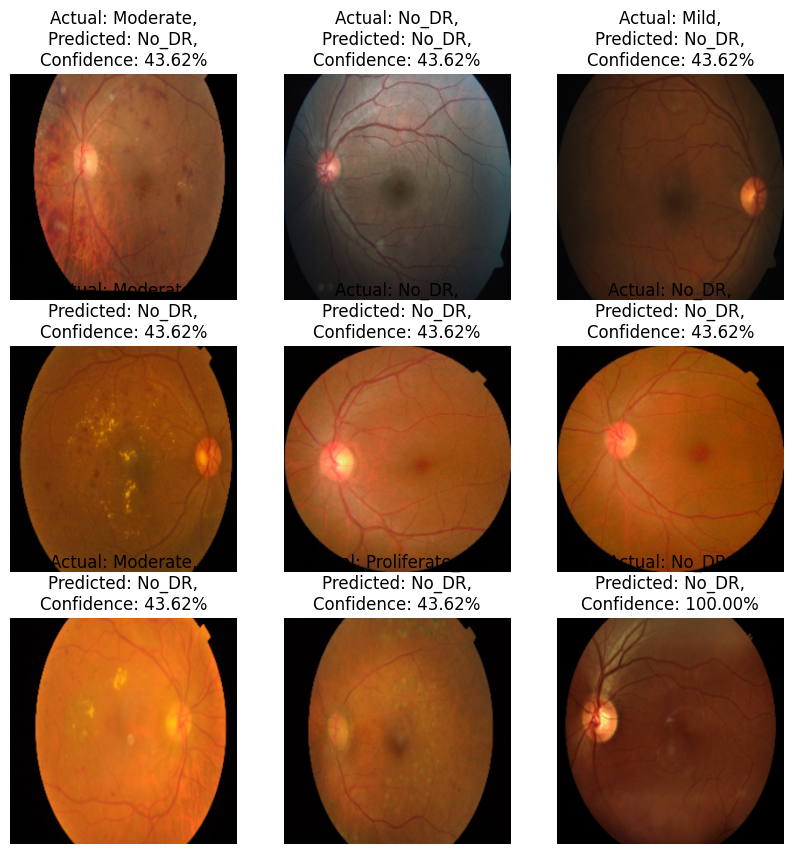

In [47]:
# Predicting on a batch of images from the test dataset

import matplotlib.pyplot as plt
import tensorflow as tf

# Your class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)  # Add batch dimension
    predictions = model.predict(image_array)
    predicted_class_idx = tf.argmax(predictions[0]).numpy()
    predicted_class = class_names[predicted_class_idx]
    confidence = 100 * tf.reduce_max(predictions[0]).numpy()
    return predicted_class, confidence

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # Use test_ds instead of test_generator
    print("Labels in batch:", labels.numpy())
    num_images = min(len(labels), 9)  # Avoid exceeding batch size
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]  # Integer label
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence:.2f}%")
        plt.axis("off")
    break
plt.show()

In [48]:
# Save the trained model
import os

model_version = "2"
save_dir = f"/Users/md.mahedihassan/My Data/Thesis Diabetic/Days/Aug 01/model/{model_version}/model.keras"  # Add .keras extension
os.makedirs(os.path.dirname(save_dir), exist_ok=True)  # Create directory if it doesn't exist
model.save(save_dir)